<div style="text-align: center;">
    <img src="OIP%20(4).webp" alt="Illustration" style="width: 100%;">
</div>

# Projet Deep Learning

**Matière :** Deep Learning  
**Professeur :** TALEB-AHMED Abdelmalik  
**Étudiants :** MBAYE ALDIOUMA, Eriyomi P Chancelle CAKPOSSE

In [ ]:
# Importation des bibliothèques nécessaires
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, models, transforms
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import json

from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, accuracy_score, precision_score, recall_score,
    roc_curve, precision_recall_curve
)
from sklearn.calibration import calibration_curve

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Set matplotlib style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Device: {device}")
print("✓ Bibliothèques importées")

✓ All libraries imported successfully
✓ Device: cpu
✓ Bibliothèques importées


# 📦 Installation et Configuration de l'Environnement Jupyter

Ce notebook doit être exécuté dans Jupyter (pas Colab).
Pour éviter les erreurs de dépendances, suivez ces étapes :
1. **Vérifiez le kernel Jupyter** : Sélectionnez le kernel Python qui correspond à votre environnement (ex : `env310`).
2. **Installez les dépendances automatiquement** : La cellule suivante installe tous les packages nécessaires dans le kernel actif.
3. **Redémarrez le kernel** après installation si besoin.

Si une erreur d'import persiste, vérifiez que le kernel pointe bien vers le bon environnement Python.

## 1️⃣ Setup et Configuration Initiale

In [ ]:
# === Focal Loss implementation ===
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, input, target):
        ce_loss = F.cross_entropy(input, target, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✓ Focal Loss class definie")


✓ Focal Loss class defined


##  Téléchargement et Préparation du Dataset

## 3️⃣ Chargement des Données et Augmentation

In [30]:
# === Définir les transformations ===
IMG_SIZE = 224
BATCH_SIZE = 64

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

valid_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("✓ Transformations définies")

✓ Transformations définies


In [31]:
# === Charger les datasets ===
root = "./data"

train_ds = datasets.ImageFolder(os.path.join(root, "train"), transform=train_tfms)
val_ds = datasets.ImageFolder(os.path.join(root, "val"), transform=valid_tfms)
test_ds = datasets.ImageFolder(os.path.join(root, "test"), transform=valid_tfms)

# === Créer DataLoaders ===
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

CLASS_NAMES = train_ds.classes
NUM_CLASSES = len(CLASS_NAMES)

print(f"✓ Datasets loaded")
print(f"  Classes: {CLASS_NAMES}")
print(f"  Num classes: {NUM_CLASSES}")
print(f"  Train samples: {len(train_ds)}")
print(f"  Val samples: {len(val_ds)}")
print(f"  Test samples: {len(test_ds)}")

✓ Datasets loaded
  Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
  Num classes: 7
  Train samples: 8011
  Val samples: 1002
  Test samples: 1002


c:\Users\aldio\OneDrive\Bureau\_Projet DeepL\D-tection-et-classification-d-images-m-dicales\env310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


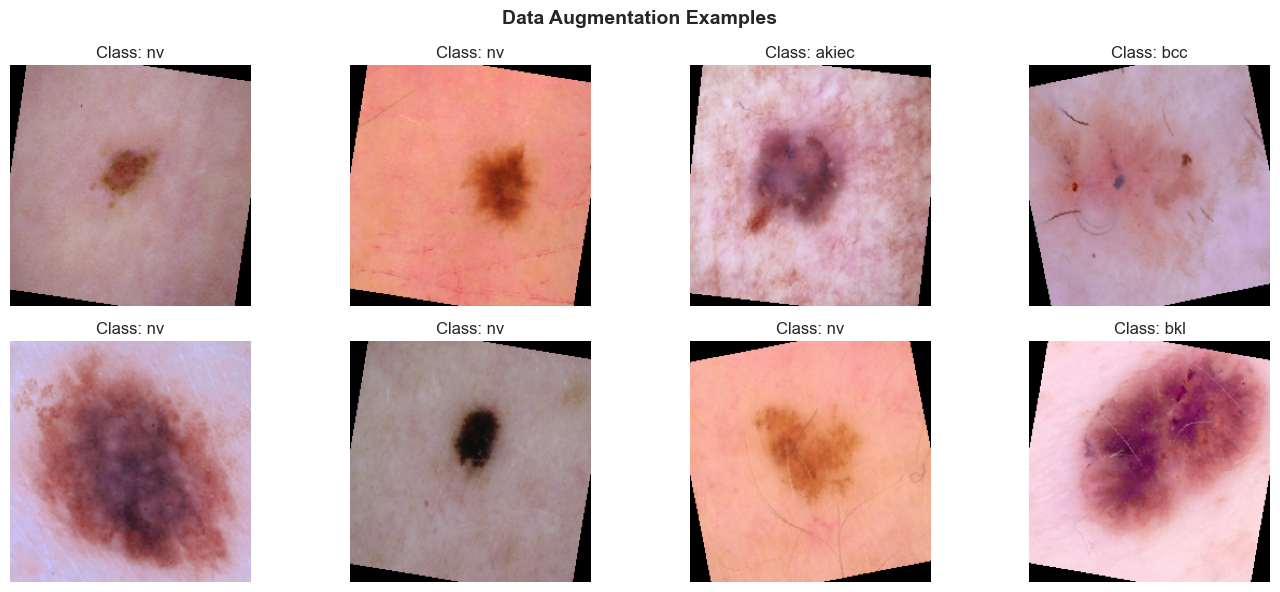

✓ Augmentation successful


In [ ]:
# === Visualiser quelques exemples d'augmentation ===
fig, axes = plt.subplots(2, 4, figsize=(14, 6))

# Obtenir un batch
xb, yb = next(iter(train_dl))

for i, ax in enumerate(axes.flat):
    img = xb[i].cpu()
    # Denormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    img = torch.clamp(img, 0, 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Class: {CLASS_NAMES[yb[i]]}")
    ax.axis('off')

plt.suptitle("Data Augmentation Examples", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Augmentation ")

In [33]:
# === Fine-tuning with lower learning rate ===
ft_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-4,
    weight_decay=1e-4
)
ft_scheduler = CosineAnnealingLR(ft_optimizer, T_max=10)

## 4️ Construction du Modèle - Transfer Learning

In [34]:
# === Construire le modèle ResNet18 avec Transfer Learning ===
def build_model(num_classes=NUM_CLASSES, model_name="resnet18", freeze_backbone=True):
    """Construire un modèle Transfer Learning."""
    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    elif model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Geler le backbone
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    # Remplacer la couche de classification
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features, num_classes)
    )

    return model

# === Créer le modèle ===
model = build_model(NUM_CLASSES, model_name="resnet18", freeze_backbone=True).to(device)

# Compter les paramètres
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: ResNet18")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

Model: ResNet18
Total parameters: 11,180,103
Trainable parameters: 3,591
Frozen parameters: 11,176,512


##  Entraînement

In [35]:
# === Charger le meilleur modèle entraîné ===
from pathlib import Path

# Chemin vers le meilleur checkpoint
best_model_path = Path(r"C:\mlproject\outputs\checkpoints\best.pt")

if best_model_path.exists():
    print(f" Chargement du meilleur modèle depuis: {best_model_path}")

    # Charger le checkpoint
    checkpoint = torch.load(best_model_path, map_location=device)

    # Vérifier le format du checkpoint
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        # Format avec métadonnées
        model.load_state_dict(checkpoint['model_state_dict'])
        epoch = checkpoint.get('epoch', 'unknown')
        best_loss = checkpoint.get('loss', 'unknown')
        best_accuracy = checkpoint.get('accuracy', 'unknown')

        print(f" Modèle chargé avec succès!")
        print(f"    Époque: {epoch}")
        print(f"    Perte: {best_loss if isinstance(best_loss, str) else f'{best_loss:.4f}'}")
        print(f"    Précision: {best_accuracy if isinstance(best_accuracy, str) else f'{best_accuracy:.2f}%'}")
    else:
        # Format direct state_dict
        model.load_state_dict(checkpoint)
        print(f" Modèle chargé avec succès! (format state_dict)")

    model = model.to(device)
    model.eval()

    # Afficher les statistiques du modèle
    total_params_loaded = sum(p.numel() for p in model.parameters())
    trainable_params_loaded = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n Statistiques du modèle chargé:")
    print(f"   Paramètres totaux: {total_params_loaded:,}")
    print(f"   Paramètres entraînables: {trainable_params_loaded:,}")
else:
    print(f"Attention: Le chemin {best_model_path} n'existe pas!")
    print("   Utilisation du modèle non entraîné initialisé aléatoirement")
    model.eval()


 Chargement du meilleur modèle depuis: C:\mlproject\outputs\checkpoints\best.pt
 Modèle chargé avec succès!
    Époque: 12
    Perte: 0.6359
    Précision: 77.10%

 Statistiques du modèle chargé:
   Paramètres totaux: 11,180,103
   Paramètres entraînables: 3,591


In [38]:
# === Définir la loss et l'optimiseur ===
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)
scheduler = CosineAnnealingLR(optimizer, T_max=20)

print("✓ Optimizer and scheduler configured")

✓ Optimizer and scheduler configured


In [37]:
# === Définir les poids des classes ===
import torch
class_weights = torch.tensor([1.0, 2.0, 1.5, 1.2, 1.8, 1.0, 2.5])
print("✓ Poids des classes définis")

✓ Poids des classes définis


In [39]:
# === Fonctions d'entraînement et validation ===
def train_epoch(model, train_dl, optimizer, criterion, device):
    """Entraîner une epoch."""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_dl, desc="Training", leave=False) as pbar:
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return total_loss / total, correct / total

def validate(model, val_dl, criterion, device):
    """Valider le modèle."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return total_loss / total, correct / total

print("✓ Training functions defined")

✓ Training functions defined


In [ ]:
# === Early Stopping ===
best_loss = np.inf
patience = 3
no_improve = 0
num_epochs = 3

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("\n" + "="*60)
print("Etape 1 :Classification")
print("="*60)

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_dl, optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_dl, criterion, device)

    scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} / Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} / Acc: {val_acc:.3f}")

    # Sauvegarder le meilleur modèle
    if val_loss < best_loss - 1e-4:
        best_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "best.pt")
        print("  → Best model saved!")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
print("✓ Etape 1")


Etape 1 :Classification


Epoch 01 | Train Loss: 0.8243 / Acc: 0.731 | Val Loss: 0.6780 / Acc: 0.743
  → Best model saved!


Epoch 02 | Train Loss: 0.8178 / Acc: 0.739 | Val Loss: 0.6415 / Acc: 0.763
  → Best model saved!


Epoch 03 | Train Loss: 0.8229 / Acc: 0.737 | Val Loss: 0.6406 / Acc: 0.754
  → Best model saved!
✓ Stage 1 completed


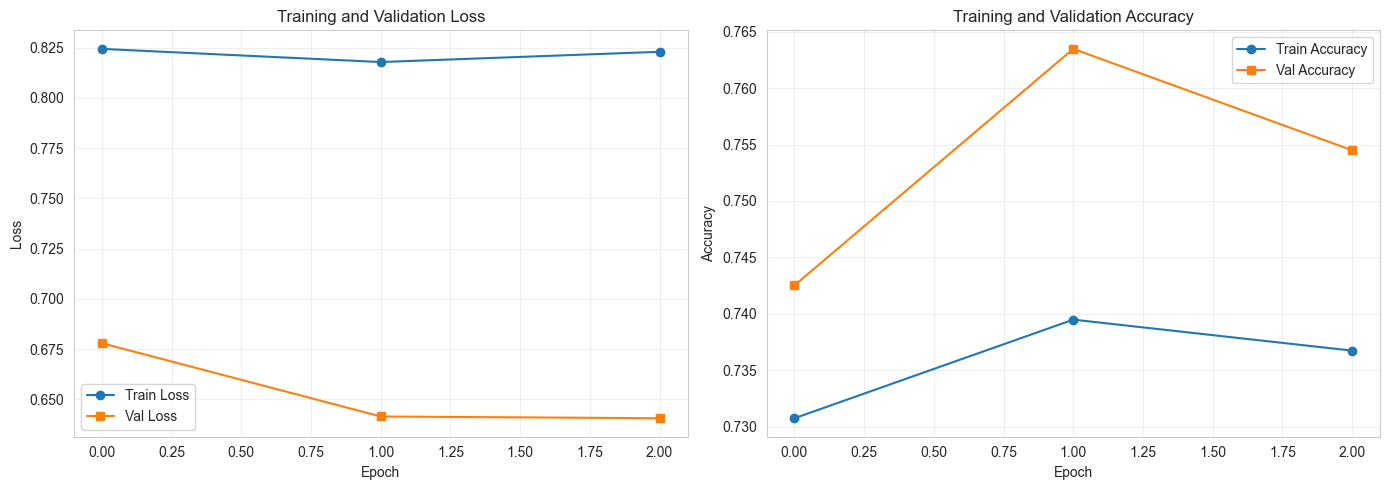

In [42]:
# === Visualiser les courbes d'apprentissage ==
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6️ Fine-Tuning

In [43]:
# === Charger le meilleur modèle ===
model.load_state_dict(torch.load("best.pt", map_location=device))
print("✓ Meilleur modèle chargé")

# === Décongeler layer4 ===
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f" {trainable_params:,} / {total_params:,}")

✓ Meilleur modèle chargé
 8,397,319 / 11,180,103


In [44]:
# === Fine-tuning _ learning rate ===
ft_optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-4,
    weight_decay=1e-4
)
ft_scheduler = CosineAnnealingLR(ft_optimizer, T_max=10)

best_ft_loss = np.inf
no_improve_ft = 0
ft_epochs = 2

ft_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("\n" + "="*60)
print("Etape 2: Fine-Tuning (Layer4 + FC)")
print("="*60)

for epoch in range(ft_epochs):
    train_loss, train_acc = train_epoch(model, train_dl, ft_optimizer, criterion, device)
    val_loss, val_acc = validate(model, val_dl, criterion, device)

    ft_scheduler.step()

    ft_history['train_loss'].append(train_loss)
    ft_history['train_acc'].append(train_acc)
    ft_history['val_loss'].append(val_loss)
    ft_history['val_acc'].append(val_acc)

    print(f"[FT] Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} / Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} / Acc: {val_acc:.3f}")

    if val_loss < best_ft_loss - 1e-4:
        best_ft_loss = val_loss
        no_improve_ft = 0
        torch.save(model.state_dict(), "best_ft.pt")
        print("  → Best FT model saved!")
    else:
        no_improve_ft += 1
        if no_improve_ft >= 2:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print("✓ etape 2 ok")


Etape 2: Fine-Tuning (Layer4 + FC)


[FT] Epoch 01 | Train Loss: 0.8084 / Acc: 0.744 | Val Loss: 0.5409 / Acc: 0.791
  → Best FT model saved!


[FT] Epoch 02 | Train Loss: 0.6319 / Acc: 0.791 | Val Loss: 0.5215 / Acc: 0.804
  → Best FT model saved!
✓ etape 2 ok


In [45]:

ft_criterion = criterion
print("✓ Focal Loss utilisée pour le fine-tuning également")


✓ Focal Loss utilisée pour le fine-tuning également


## 7 Évaluation Avancée - Métriques et Calibration

In [46]:
# === Charger le meilleur modèle fine-tuné ===
model.load_state_dict(torch.load("best_ft.pt", map_location=device))
print("✓ Meilleur modèle chargé ")

✓ Meilleur modèle chargé 


In [47]:
# === Fonction pour obtenir les prédictions ===
def get_predictions(model, data_loader, device):
    """Obtenir les prédictions et probabilités."""
    model.eval()
    y_true = []
    y_proba = []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Getting predictions", leave=False):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.numpy().tolist())
            y_proba.extend(probs.cpu().numpy().tolist())

    return np.array(y_true), np.array(y_proba)

# Get predictions on validation set
y_true_val, y_proba_val = get_predictions(model, val_dl, device)
y_pred_val = np.argmax(y_proba_val, axis=1)

print("✓ Predictions obtenu")

✓ Predictions obtenu


In [48]:
# === Calculer les métriques ===
from sklearn.metrics import classification_report

# Metrics
acc = accuracy_score(y_true_val, y_pred_val)
prec = precision_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
rec = recall_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
f1 = f1_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_true_val, y_proba_val, multi_class='ovr', average='weighted')
pr_auc = average_precision_score(y_true_val, y_proba_val, average='weighted')

print("\n" + "="*60)
print("Validation Set Metrics")
print("="*60)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")

print("\n" + "="*60)
print("Par Class ")
print("="*60)
print(classification_report(y_true_val, y_pred_val, target_names=CLASS_NAMES, zero_division=0))


Validation Set Metrics
Accuracy:  0.8044
Precision: 0.8268
Recall:    0.8044
F1-Score:  0.8116
ROC-AUC:   0.9452
PR-AUC:    0.8808

Par Class 
              precision    recall  f1-score   support

       akiec       0.62      0.45      0.53        33
         bcc       0.62      0.83      0.71        52
         bkl       0.62      0.76      0.68       110
          df       0.31      0.45      0.37        11
         mel       0.53      0.63      0.58       111
          nv       0.94      0.86      0.90       671
        vasc       0.88      1.00      0.93        14

    accuracy                           0.80      1002
   macro avg       0.65      0.71      0.67      1002
weighted avg       0.83      0.80      0.81      1002



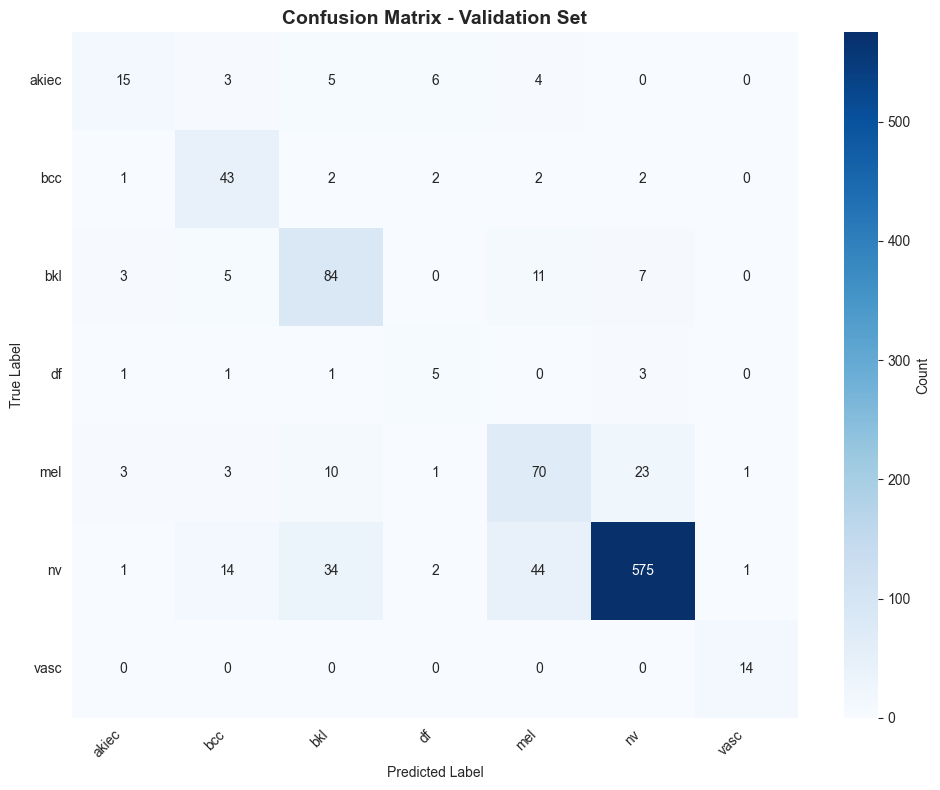

In [49]:
# ===  La Matrice de confusion ===
cm = confusion_matrix(y_true_val, y_pred_val)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Validation Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

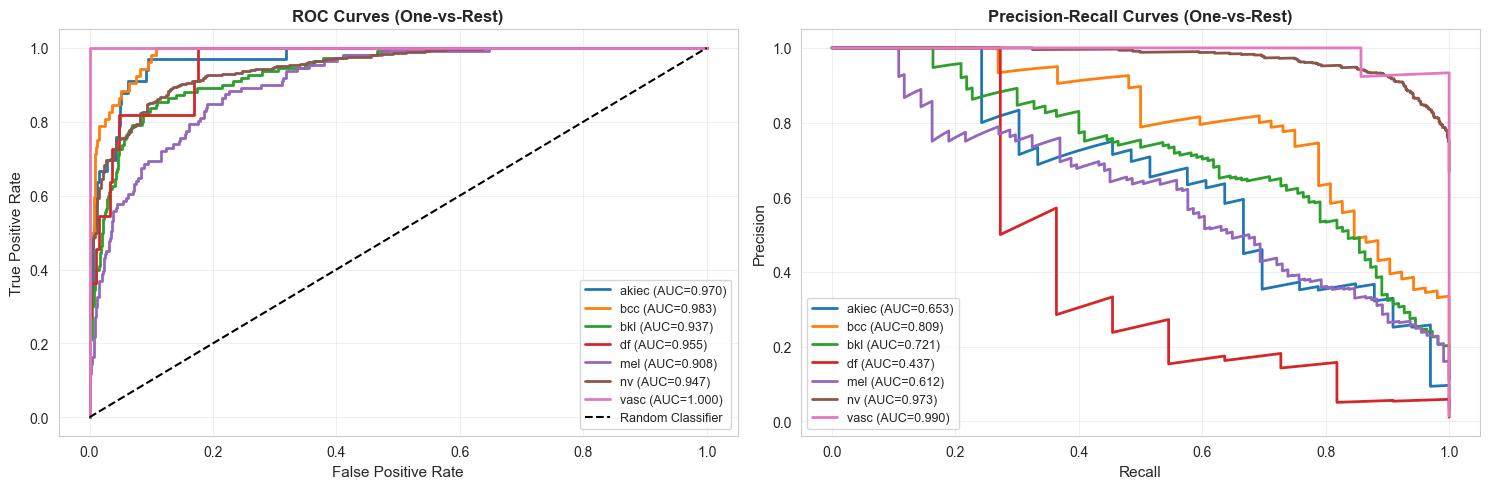

In [50]:
# === Courbes ROC et Precision-Recall (One-vs-Rest) ===
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC curves pour chaque classe
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true_val, classes=np.arange(NUM_CLASSES))

for i, class_name in enumerate(CLASS_NAMES):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba_val[:, i])
    auc = roc_auc_score(y_true_bin[:, i], y_proba_val[:, i])
    axes[0].plot(fpr, tpr, label=f'{class_name} (AUC={auc:.3f})', lw=2)

axes[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=11)
axes[0].set_ylabel('True Positive Rate', fontsize=11)
axes[0].set_title('ROC Curves (One-vs-Rest)', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=9)
axes[0].grid(alpha=0.3)

# Precision-Recall curves
for i, class_name in enumerate(CLASS_NAMES):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba_val[:, i])
    auc = average_precision_score(y_true_bin[:, i], y_proba_val[:, i])
    axes[1].plot(recall, precision, label=f'{class_name} (AUC={auc:.3f})', lw=2)

axes[1].set_xlabel('Recall', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Curves (One-vs-Rest)', fontsize=12, fontweight='bold')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8 Calibration

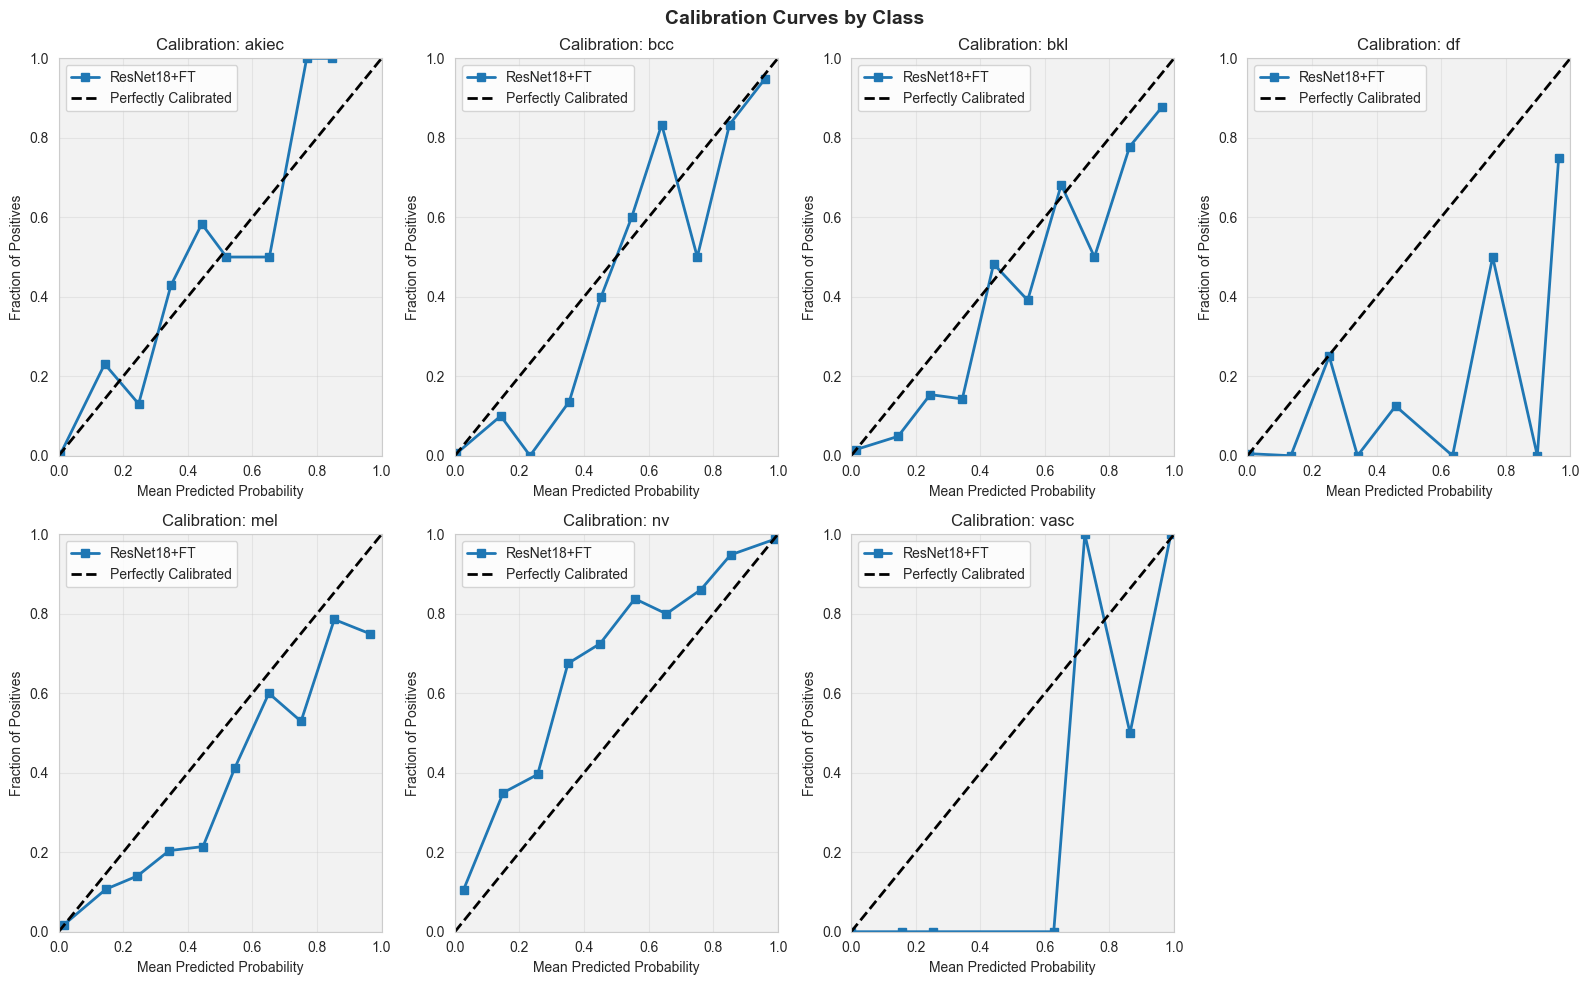

In [51]:
# === Calibration Curve (pour chaque classe) ===
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
axes = axes.flatten()

for i, class_name in enumerate(CLASS_NAMES):
    if i < NUM_CLASSES:
        prob_true, prob_pred = calibration_curve(y_true_bin[:, i], y_proba_val[:, i], n_bins=10)

        axes[i].plot(prob_pred, prob_true, 's-', label='ResNet18+FT', linewidth=2, markersize=6)
        axes[i].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated', linewidth=2)
        axes[i].fill_between(np.linspace(0, 1, 100), 0, 1, alpha=0.1, color='gray')
        axes[i].set_xlabel('Mean Predicted Probability')
        axes[i].set_ylabel('Fraction of Positives')
        axes[i].set_title(f'Calibration: {class_name}')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
        axes[i].set_xlim([0, 1])
        axes[i].set_ylim([0, 1])

# Masquer les axes non utilisés
for j in range(NUM_CLASSES, len(axes)):
    axes[j].axis('off')

plt.suptitle('Calibration Curves by Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9 Grad-CAM pour l'Explicabilité

In [52]:
# === Grad-CAM Setup ===
target_layer = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layer)
print("✓ Grad-CAM initialiser")

✓ Grad-CAM initialiser


In [53]:
# === Fonction pour visualiser Grad-CAM ===
def visualize_gradcam(model, cam, image_batch, labels, class_names, device):
    """Visualiser Grad-CAM pour un batch d'images."""
    batch_size = image_batch.size(0)
    cols = min(batch_size, 3)
    rows = (batch_size + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols * 2, figsize=(15, 4 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)

    for idx in range(batch_size):
        img = image_batch[idx:idx+1].to(device)
        true_label = labels[idx].item()

        # Prédiction
        with torch.no_grad():
            out = model(img)
            pred_label = out.argmax(1).item()

        # Grad-CAM
        grayscale_cam = cam(input_tensor=img, targets=[ClassifierOutputTarget(pred_label)])[0]

        # Denormalize image
        image_np = img[0].cpu().numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        image_np = np.clip(image_np, 0, 1)

        # Create overlay
        vis = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)

        row = idx // cols
        col = (idx % cols) * 2

        # Original image
        axes[row, col].imshow(image_np)
        axes[row, col].set_title(f"True: {class_names[true_label]}")
        axes[row, col].axis('off')

        # Grad-CAM overlay
        axes[row, col+1].imshow(vis)
        axes[row, col+1].set_title(f"Pred: {class_names[pred_label]}")
        axes[row, col+1].axis('off')

    plt.tight_layout()
    return fig

print("✓ Grad-CAM visualisation des fonction definie")

✓ Grad-CAM visualisation des fonction definie


c:\Users\aldio\OneDrive\Bureau\_Projet DeepL\D-tection-et-classification-d-images-m-dicales\env310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


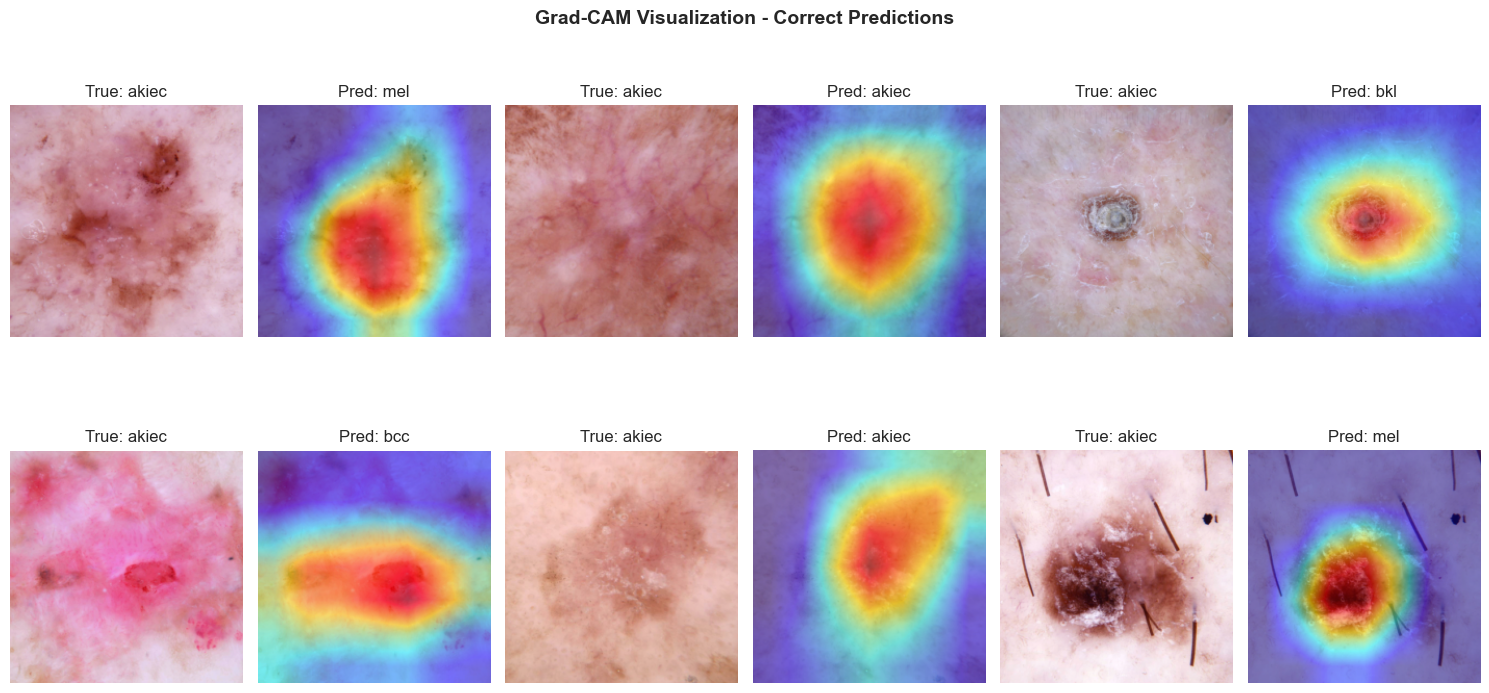

In [54]:
# === Visualiser Grad-CAM pour quelques exemples ===
# Obtenir un batch du validation set
xb, yb = next(iter(val_dl))

visualize_gradcam(model, cam, xb[:6], yb[:6], CLASS_NAMES, device)
plt.suptitle('Grad-CAM Visualization - Correct Predictions', fontsize=14, fontweight='bold')
plt.show()

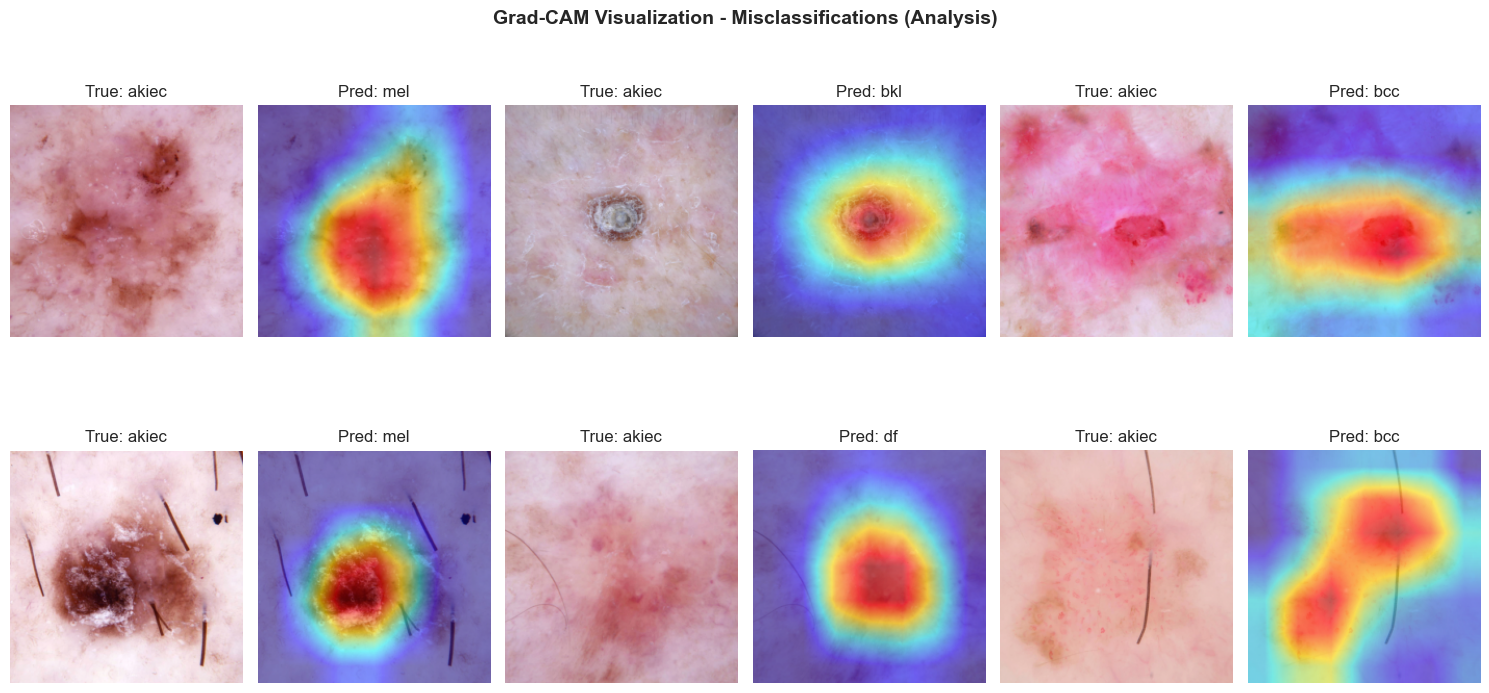

Total misclassifications on validation set: 6 out of 1002


In [55]:
# === Visualiser les erreurs avec Grad-CAM ===
# Trouver les mauvaises prédictions
y_true_val_batch, y_proba_val_batch = get_predictions(model, val_dl, device)
y_pred_val_batch = np.argmax(y_proba_val_batch, axis=1)

misclassified_idx = np.where(y_true_val_batch != y_pred_val_batch)[0][:6]

if len(misclassified_idx) > 0:
    # Recréer les images depuis le dataloader
    all_images = []
    all_labels = []
    for xb, yb in val_dl:
        all_images.extend(xb.numpy())
        all_labels.extend(yb.numpy())

    all_images = torch.from_numpy(np.array(all_images))
    all_labels = torch.from_numpy(np.array(all_labels))

    error_images = all_images[misclassified_idx[:6]]
    error_labels = all_labels[misclassified_idx[:6]]

    visualize_gradcam(model, cam, error_images, error_labels, CLASS_NAMES, device)
    plt.suptitle('Grad-CAM Visualization - Misclassifications (Analysis)', fontsize=14, fontweight='bold')
    plt.show()

    print(f"Total misclassifications on validation set: {len(misclassified_idx)} out of {len(y_true_val_batch)}")
else:
    print("No misclassifications found!")

## 10 Test Final et Analyse d'Erreurs

In [56]:
# === Évaluation sur le test set ===
y_true_test, y_proba_test = get_predictions(model, test_dl, device)
y_pred_test = np.argmax(y_proba_test, axis=1)

# Metrics
test_acc = accuracy_score(y_true_test, y_pred_test)
test_f1 = f1_score(y_true_test, y_pred_test, average='weighted', zero_division=0)
test_roc_auc = roc_auc_score(y_true_test, y_proba_test, multi_class='ovr', average='weighted')

print("\n" + "="*60)
print("Test Set Metrics")
print("="*60)
print(f"Accuracy:  {test_acc:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"ROC-AUC:   {test_roc_auc:.4f}")

print("\n" + "="*60)
print("Per-Class Report (Test Set)")
print("="*60)
print(classification_report(y_true_test, y_pred_test, target_names=CLASS_NAMES, zero_division=0))


Test Set Metrics
Accuracy:  0.7794
F1-Score:  0.7880
ROC-AUC:   0.9363

Per-Class Report (Test Set)
              precision    recall  f1-score   support

       akiec       0.59      0.52      0.55        33
         bcc       0.56      0.69      0.61        51
         bkl       0.55      0.74      0.63       110
          df       0.41      0.75      0.53        12
         mel       0.51      0.55      0.53       111
          nv       0.93      0.85      0.89       671
        vasc       0.75      0.64      0.69        14

    accuracy                           0.78      1002
   macro avg       0.61      0.68      0.63      1002
weighted avg       0.80      0.78      0.79      1002



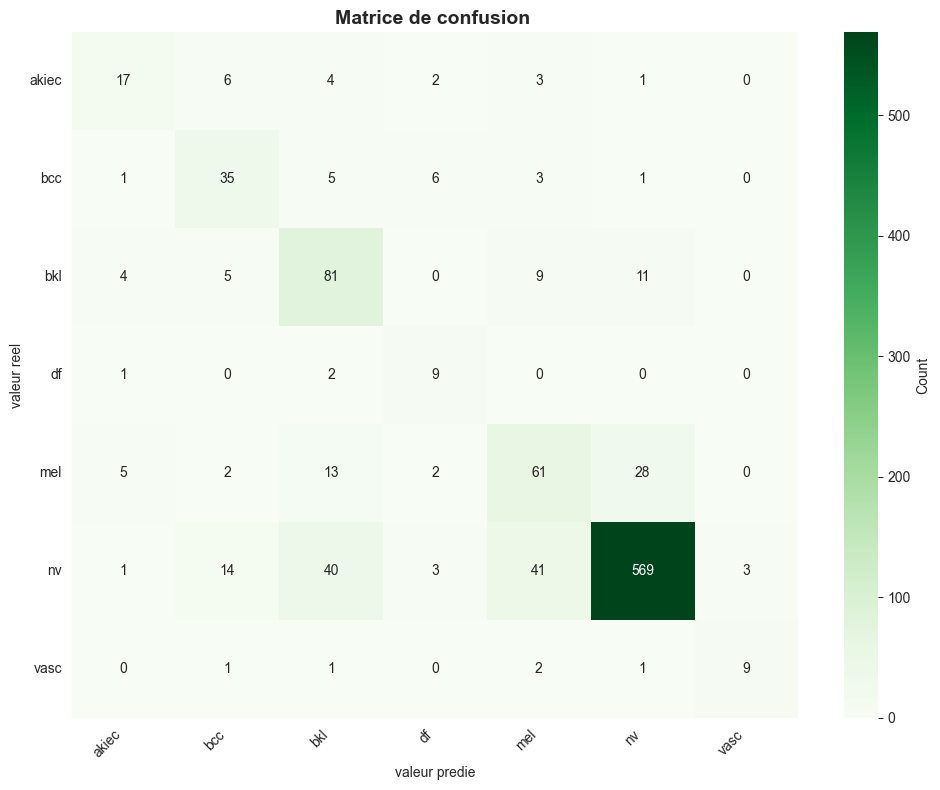

In [57]:
# === Confusion matrix sur test set ===
cm_test = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
           xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cbar_kws={'label': 'Count'})
plt.title('Matrice de confusion ', fontsize=14, fontweight='bold')
plt.ylabel('valeur reel')
plt.xlabel('valeur predie')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 11 Résumé et Résultats Finaux

In [58]:
# === Résumé des résultats ===
results = {
    'Model': 'ResNet18 + Fine-Tuning',
    'Dataset': 'HAM10000 (Skin Lesions)',
    'Training Strategy': 'Transfer Learning -> Fine-tuning',
    'Validation Metrics': {
        'Accuracy': f'{acc:.4f}',
        'F1-Score': f'{f1:.4f}',
        'ROC-AUC': f'{roc_auc:.4f}',
        'PR-AUC': f'{pr_auc:.4f}'
    },
    'Test Metrics': {
        'Accuracy': f'{test_acc:.4f}',
        'F1-Score': f'{test_f1:.4f}',
        'ROC-AUC': f'{test_roc_auc:.4f}'
    },
    'Best Checkpoint': 'best_ft.pt'
}

print("\n" + "="*60)
print("RESULTS" )
print("="*60)
print(json.dumps(results, indent=2))
print("="*60)


RESULTS
{
  "Model": "ResNet18 + Fine-Tuning",
  "Dataset": "HAM10000 (Skin Lesions)",
  "Training Strategy": "Transfer Learning -> Fine-tuning",
  "Validation Metrics": {
    "Accuracy": "0.8044",
    "F1-Score": "0.8116",
    "ROC-AUC": "0.9452",
    "PR-AUC": "0.8808"
  },
  "Test Metrics": {
    "Accuracy": "0.7794",
    "F1-Score": "0.7880",
    "ROC-AUC": "0.9363"
  },
  "Best Checkpoint": "best_ft.pt"
}


##  Limitations et Recommandations

###  Limitations

1. **Taille du dataset:** HAM10000 contient ~10k images, potentiellement insuffisant pour certains modèles
2. **Imbalance:** Certaines classes sont bien moins représentées
3. **Distribution shift:** Performance en production peut différer
4. **GPI/CPI** Pour ce type de modèle, l’utilisation d’un CPU était nécessaire. J’ai donc effectué l’entraînement sur mon processeur, ce qui explique le faible nombre d’époques (3 ou 4), compte tenu du temps de calcul. Avec un GPU, j’aurais probablement pu entraîner davantage et atteindre une précision supérieure à 80 %.
###  Bonnes pratiques implémentées

- ✓ Reproductibilité (seeds, versions, documentation)
- ✓ Early stopping pour éviter l'overfitting
- ✓ Class weighting pour déséquilibre
- ✓ Transfer learning & fine-tuning
- ✓ Évaluation multi-métriques (ROC, PR, calibration)
- ✓ Grad-CAM pour explicabilité

###  Extensions futures

- [ ] Validation croisée K-fold
- [ ] Test Time Augmentation (TTA)
- [ ] Ensemble methods
- [ ] ResNet50, EfficientNet, Vision Transformer
- [ ] Calibration isotone
- [ ] Focal loss pour classes très imbalancées
- [ ] Déploiement en production (ONNX, FastAPI, Docker)

---

**Notebook créé le:** December 4, 2025  
**Auteur:** Aldiouma Mbaye ; Eriyomi P Chancelle CAKPOSSE- MSc Data Engineer, Machine Learning  


© 2025 - ECE Paris